In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings('ignore')

<a class="anchor" id="2."></a>**Olivetti Dataset** 

In [3]:
data = np.load("./olivetti_faces.npy")
target = np.load("./olivetti_faces_target.npy")

Проверка датасета

In [4]:
print("В датасете имееется {} изображений".format(len(data)))
print("Количество уникальных объектов: {}".format(len(np.unique(target))))
print("Размерность каждого изображения {}x{}".format(data.shape[1], data.shape[2]))
print("Значения пикселей были преобразованы к интервалу [0,1]: {}".format(data[0][0,:3]))

В датасете имееется 400 изображений
Количество уникальных объектов: 40
Размерность каждого изображения 64x64
Значения пикселей были преобразованы к интервалу [0,1]: [0.30991736 0.3677686  0.41735536]


In [5]:
print("номера уникальных объектов:", np.unique(target))

номера уникальных объектов: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


<a class="anchor" id="2.1."></a>**Отображение всех лиц в датасете** 

In [6]:
def show_all_faces(images, unique_ids):
    # Создаем subplot'ы 4X10, размер фигур 18x9
    fig, axarr = plt.subplots(nrows = 4, ncols = 10, figsize = (18, 9))
    
    # Для упрощенной итерации выравниваем 4X10 матрицу subplot'ы ко списку из 40 объектов
    axarr = axarr.flatten()
    
    # Итерируемся по каждому лицу
    for unique_id in unique_ids:
        image_index = unique_id*10
        axarr[unique_id].imshow(images[image_index], cmap = "gray")
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
        
    plt.suptitle("В датасете имеется 40 лиц людей")

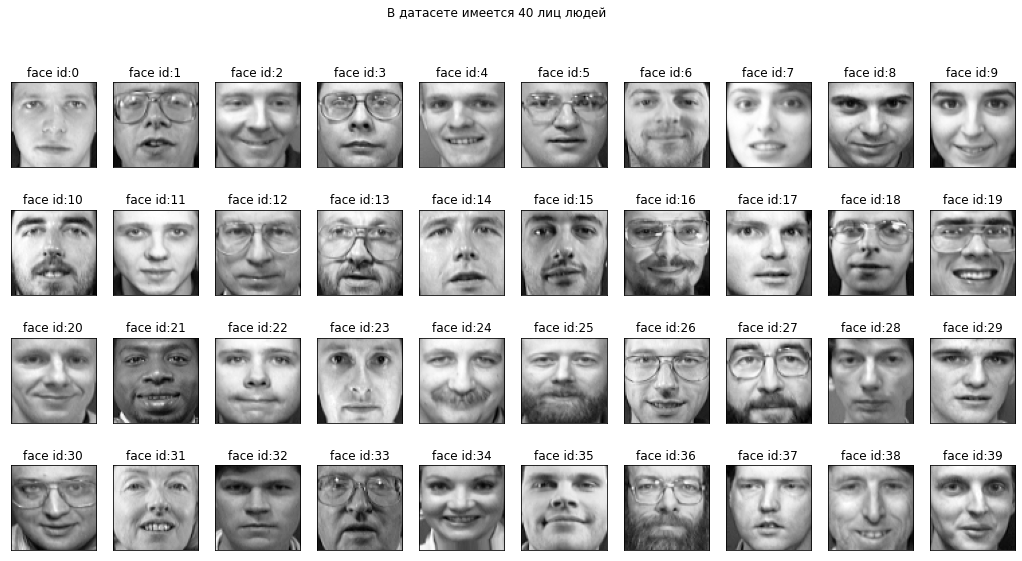

In [7]:
show_all_faces(data, np.unique(target))

<a class="anchor" id="2.2.">

<a  class="anchor" id="2.2."></a>**Отображение 10 фотографий отдельного человека** 

In [8]:
def show_10_faces_of_n_subject(images, subject_ids):
    cols = 10
    rows = (len(subject_ids)*10)/cols
    rows = int(rows)
    
    fig, axarr = plt.subplots(nrows = rows, ncols = cols, figsize = (18,9))
    #axarr=axarr.flatten()
    
    for i, subject_id in enumerate(subject_ids):
        for j in range(cols):
            image_index = subject_id*10 + j
            axarr[i,j].imshow(images[image_index], cmap = "gray")
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            axarr[i,j].set_title("face id:{}".format(subject_id))
    

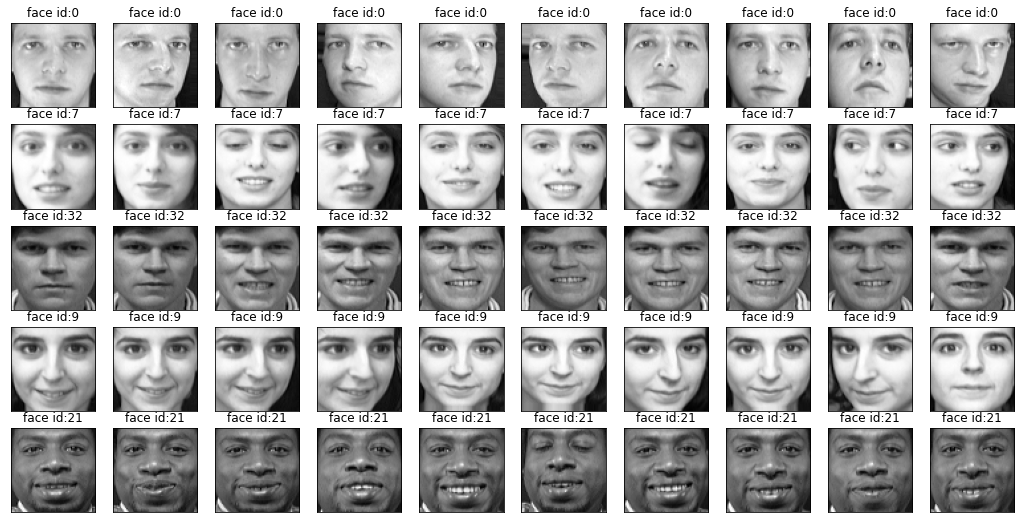

In [9]:
show_10_faces_of_n_subject(images = data, subject_ids = [0, 7, 32, 9, 21])

<a class="anchor" id="3."></a>**4.1.Модель машинного обучения для распознавания лиц**

Модели машинного обучения работают на векторах. Изображение представляет собой иформацию в матричной форме, где каждый пиксель - это список из трех значений от 0 до 256 (RGB-представление). Все это мы должны перевести в форму вектора.

In [10]:
# Изменяем shape изображений для модели МО
X = data.reshape((data.shape[0], data.shape[1] * data.shape[2]))

print("X shape:", X.shape)

X shape: (400, 4096)


<a class="anchor" id="3.1."></a>**4.2.Разделяем набор данных на тестовую и обучающую выборки** 

Набор данных содержит 10 изображений лиц для каждого сотрудника. Из изображений лиц 70 процентов будут использоваться для обучения модели, а 30 процентов — для ее тестирования. Будем использовать функцию стратификации, чтобы иметь одинаковое количество обучающих и тестовых изображений для каждого сотрудника. Таким образом, получим 7 обучающих изображений и 3 тестовых изображения для каждого человека.

In [11]:
X_train, X_test, y_train, y_test=train_test_split(X, target, test_size = 0.3,
                                                  stratify = target, random_state = 0)
print("X_train shape:", X_train.shape)
print("y_train shape:{}".format(y_train.shape))

X_train shape: (280, 4096)
y_train shape:(280,)


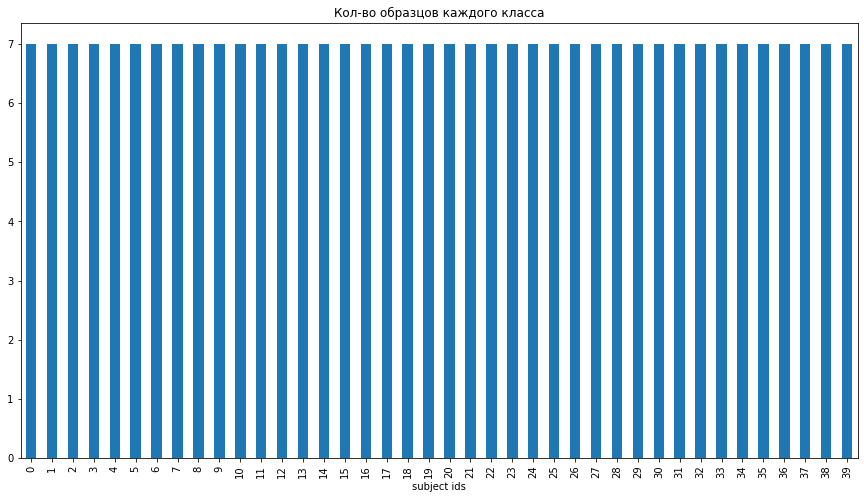

In [12]:
y_frame = pd.DataFrame()
y_frame["subject ids"] = y_train
y_frame.groupby(["subject ids"]).size().plot.bar(figsize = (15,8), title = "Кол-во образцов каждого класса")
plt.show()

<a class="anchor" id="3.2."></a>**4.3.Метод главных компонент**

В основном, методы машинного обучения делятся на два типа: обучение с учителем и без. При обучении с учителем набор данных делится на две основные части: «data» и «output». Термин «data» подразумевает содержание значений выборки в нашем датасете, а «output», другими словами, выходные данные содержат класс (для классификации) или целевое значение (для регрессии). В случае обучения без учителя набор данных состоит только из раздела самих данных.

В свою же очередь, обучение без учителя обычно делится на следующие две части: преобразование данных и кластеризация. В этой работе преобразование данных будет осуществляться с использованием неконтролируемого обучения, так как оно позволяет упростить интерпретацию данных компьютерами и людьми.

Наиболее популярное применение неконтролируемые преобразования имеют в вопросах уменьшения объема данных. В данной работе, например, потребуется уменьшение размерности.

Принцип главных компонент (PCA) — это метод, позволяющий трансформировать и представить данные в меньшем размере без потери ценной информации. Согласно этому методу, данные преобразуются в новые компоненты, а размер данных уменьшается за счет фильтрации и отброса ненужных частей.


In [13]:
# !pip install mglearn
import mglearn

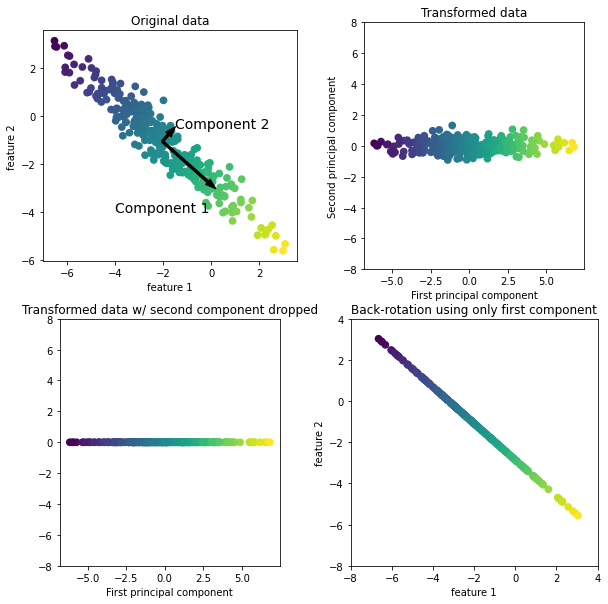

In [14]:
mglearn.plots.plot_pca_illustration()

На приведенной выше иллюстрации(см. рис.7) изображен простой пример синтетического набора двумерных данных. На первом рисунке показаны исходные точки данных, окрашенные для различения. Алгоритм сначала ищет направление максимальной дисперсии, помеченное как «Component 1». Здесь подразумевается то направление, в котором сконцентрирована большая часть данных, или, иными словами, направление к свойствам, которые наиболее связаны друг с другом.

Затем, когда алгоритм ортогонален (находится под прямым углом), он находит направление, которое содержит больше всего информации в первом направлении. Существует только одна возможная ориентация в двух измерениях под прямым углом, но будет много ортогональных направлений (бесконечных) в многомерных пространствах.

<a class="anchor" id="3.3."></a>**4.4. Проекция метода главных компонент на n-человек**

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(X)

X_pca = pca.transform(X)

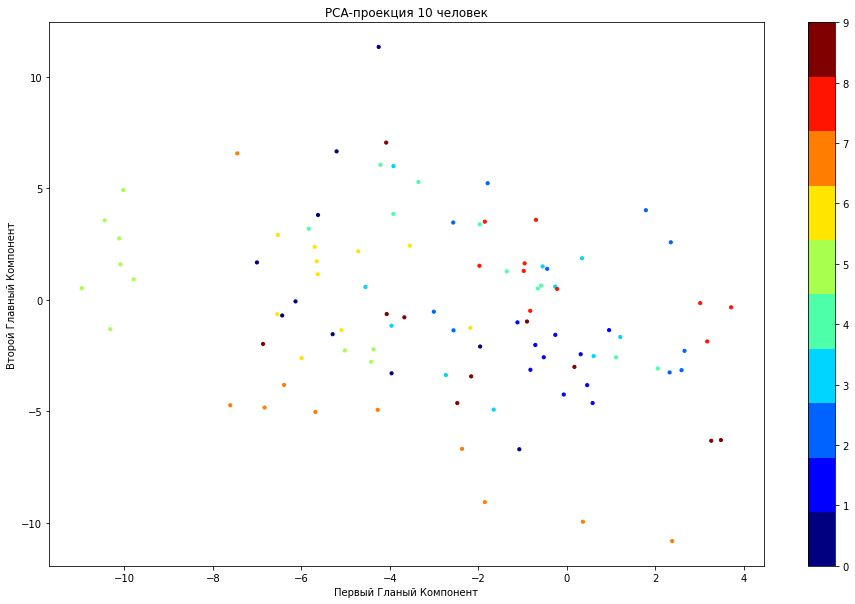

In [16]:
number_of_people=10
index_range = number_of_people * 10
 
fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(1,1,1)

scatter = ax.scatter(X_pca[:index_range,0],
            X_pca[:index_range,1],
            c=target[:index_range],
            s=10,
           cmap=plt.get_cmap("jet", number_of_people)
          )

ax.set_xlabel("Первый Гланый Компонент")
ax.set_ylabel("Второй Главный Компонент")
ax.set_title("PCA-проекция {} человек".format(number_of_people))

fig.colorbar(scatter)
plt.show()

<a class="anchor" id="3.4."></a>**4.4. Нахождение отпимального числа главных компонент**

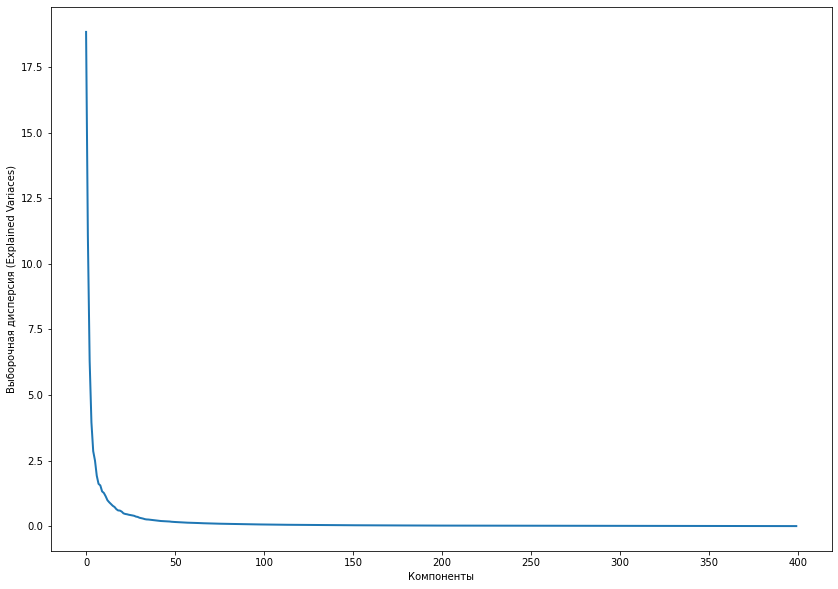

In [17]:
pca = PCA()
pca.fit(X)

plt.figure(1, figsize = (14,10))

plt.plot(pca.explained_variance_, linewidth = 2)
 
plt.xlabel("Компоненты")
plt.ylabel("Выборочная дисперсия (Explained Variaces)")
plt.show()

На изображении выше (см. рис.9) видим, что 90+ PCA-компонентов представляют одну и ту же информацию. Далее проведем процесс классификации, используя этот набор компонентов.

In [18]:
n_components=90

In [19]:
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train)

PCA(n_components=90, whiten=True)

<a class="anchor" id="3.5."></a>**4.5. Иллюстрация "Average Face"**  

Text(0.5, 1.0, 'Average Face')

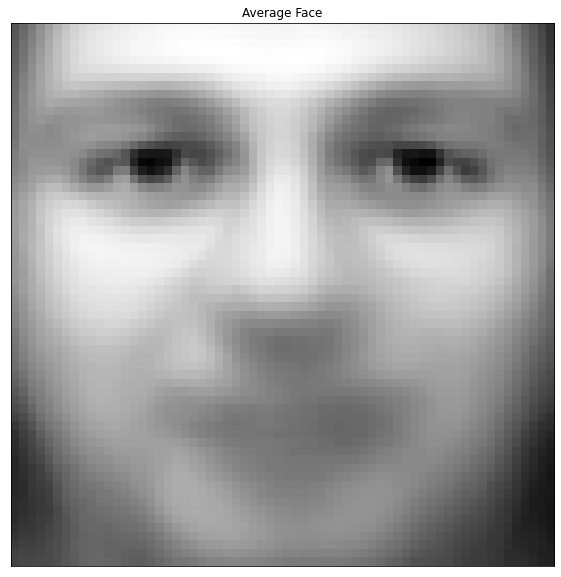

In [20]:
fig,ax = plt.subplots(1, 1, figsize = (10,10))
ax.imshow(pca.mean_.reshape((64,64)), cmap = "gray")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Average Face")

<a class="anchor" id="3.5e1."></a>**4.6. Show Eigen Faces** 

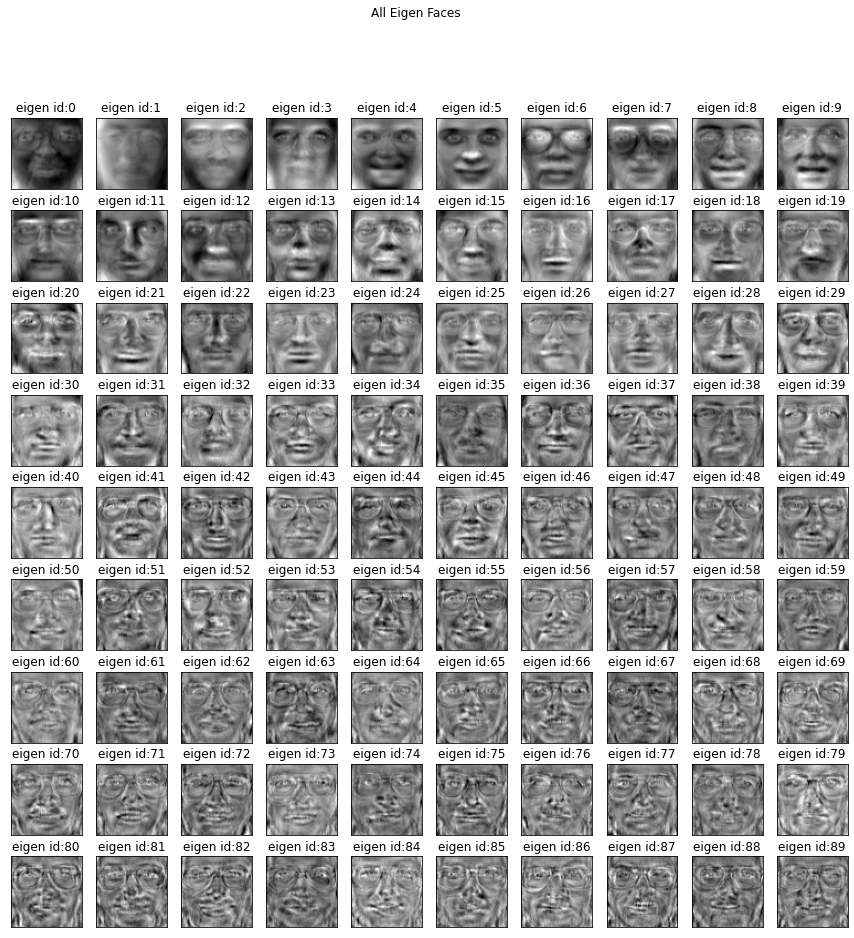

In [21]:
number_of_eigenfaces=len(pca.components_)
eigen_faces = pca.components_.reshape((number_of_eigenfaces, data.shape[1], data.shape[2]))

cols = 10
rows = int(number_of_eigenfaces/cols)
fig, axarr = plt.subplots(nrows = rows, ncols = cols, figsize = (15,15))
axarr = axarr.flatten()

for i in range(number_of_eigenfaces):
    axarr[i].imshow(eigen_faces[i],cmap = "gray")
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title("eigen id:{}".format(i))
    
plt.suptitle("All Eigen Faces".format(10 * "=", 10 * "="))
plt.show()

<a class="anchor" id="3.6."></a>**5. Результаты классификации**  

In [22]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [23]:
clf = SVC()
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

# accuracy score
print("Точность составляет: {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))

Точность составляет: 0.92


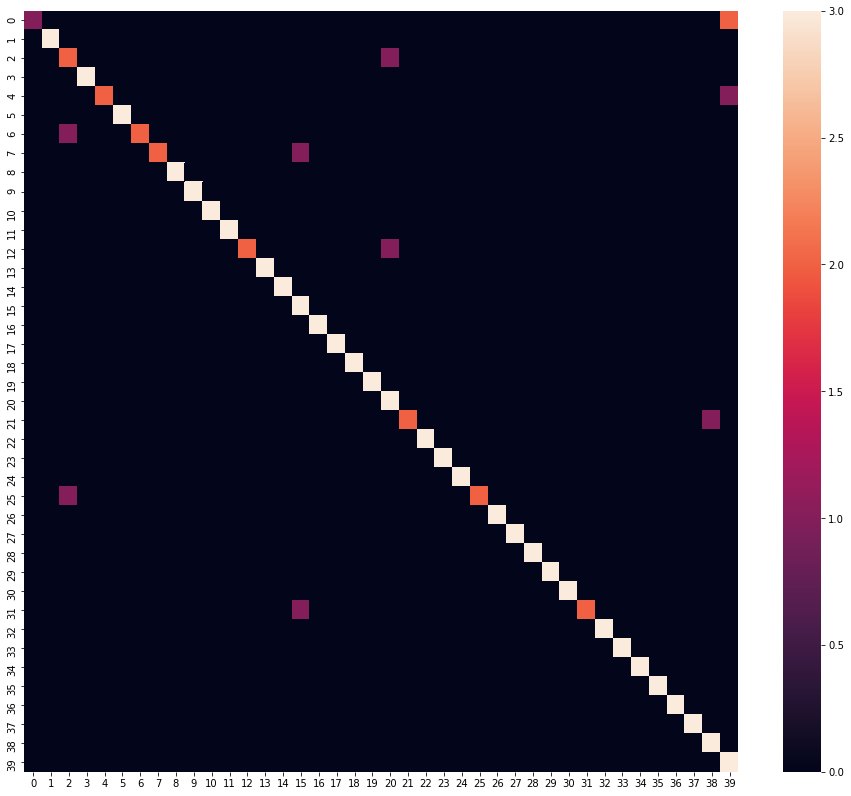

In [24]:
import seaborn as sns

plt.figure(1, figsize = (16 ,14))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred))
plt.show()

In [25]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       1.00      1.00      1.00         3
           2       0.50      0.67      0.57         3
           3       1.00      1.00      1.00         3
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         3
           6       1.00      0.67      0.80         3
           7       1.00      0.67      0.80         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      0.67      0.80         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       0.60      1.00      0.75         3
          16       1.00      1.00      1.00         3
          17       1.00    

<a class="anchor" id="3.7."></a>**5.1. Результаты других моделей** 

We can get accuracy results of state of the art machine learning model.

======= МОДЕЛЬ SVM =======
Точность составляет: 0.92
Затраченное время в секундах: 0.0311

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       1.00      1.00      1.00         3
           2       0.50      0.67      0.57         3
           3       1.00      1.00      1.00         3
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         3
           6       1.00      0.67      0.80         3
           7       1.00      0.67      0.80         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      0.67      0.80         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       0.60      1.00      0.75 

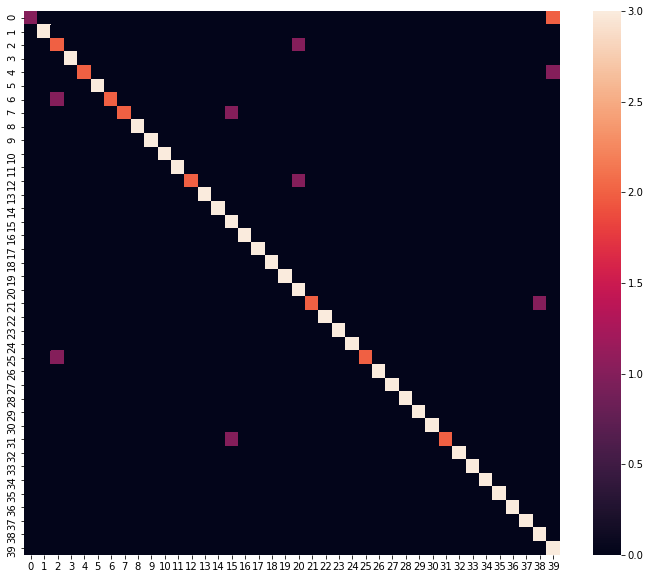



======= МОДЕЛЬ KNN =======
Точность составляет: 0.70
Затраченное время в секундах: 0.0089

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       1.00      0.67      0.80         3
           2       0.67      0.67      0.67         3
           3       0.67      0.67      0.67         3
           4       0.40      0.67      0.50         3
           5       0.50      0.67      0.57         3
           6       1.00      0.33      0.50         3
           7       1.00      0.67      0.80         3
           8       0.50      1.00      0.67         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       0.00      0.00      0.00         3
          12       1.00      0.33      0.50         3
          13       1.00      1.00      1.00         3
          14       0.43      1.00      0.60         3
          15       1.00      0.33      0.5

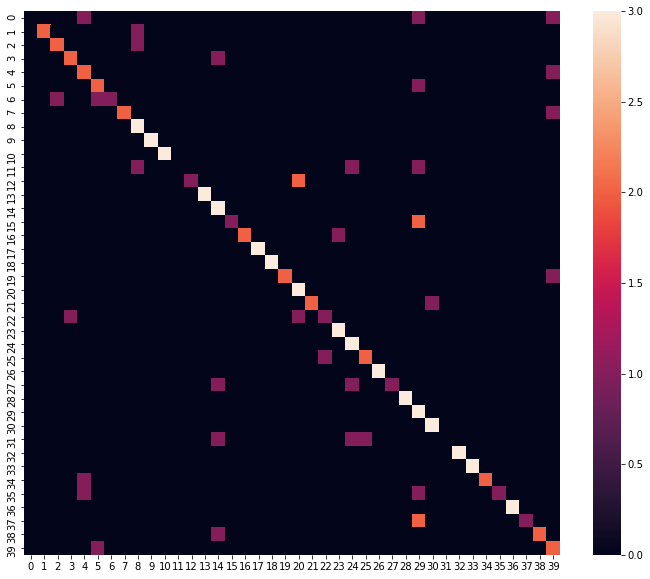



======= МОДЕЛЬ LR =======
Точность составляет: 0.93
Затраченное время в секундах: 0.0418

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       1.00      1.00      1.00         3
           2       0.67      0.67      0.67         3
           3       1.00      1.00      1.00         3
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      0.67      0.80         3
           8       0.75      1.00      0.86         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      0.67      0.80         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00

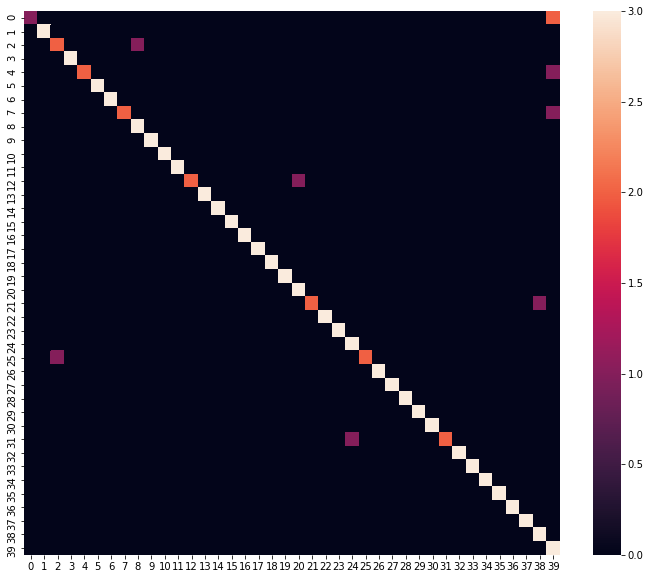



======= МОДЕЛЬ DT =======
Точность составляет: 0.60
Затраченное время в секундах: 0.0259

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      0.67      0.80         3
           2       0.50      0.33      0.40         3
           3       0.25      0.33      0.29         3
           4       1.00      0.33      0.50         3
           5       1.00      1.00      1.00         3
           6       0.50      0.33      0.40         3
           7       1.00      0.67      0.80         3
           8       1.00      1.00      1.00         3
           9       1.00      0.67      0.80         3
          10       1.00      0.67      0.80         3
          11       1.00      0.33      0.50         3
          12       0.00      0.00      0.00         3
          13       1.00      0.67      0.80         3
          14       0.33      0.67      0.44         3
          15       0.50      0.33      0.40

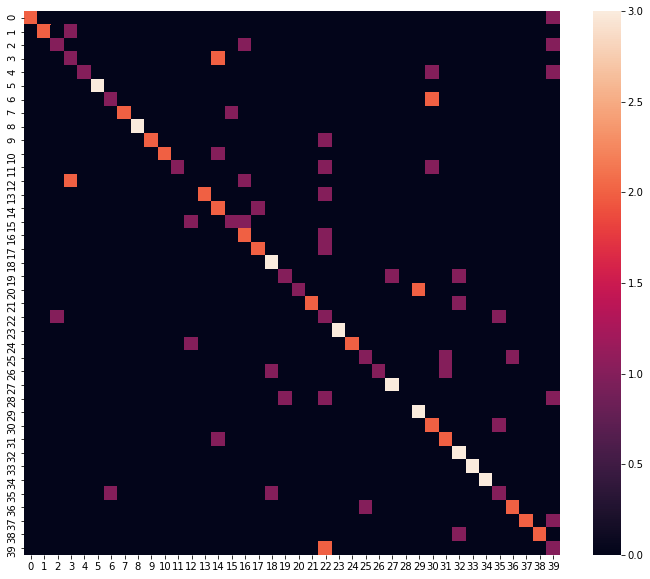



======= МОДЕЛЬ LDA =======
Точность составляет: 0.93
Затраченное время в секундах: 0.0088

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      0.67      0.80         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       0.67      0.67      0.67         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.0

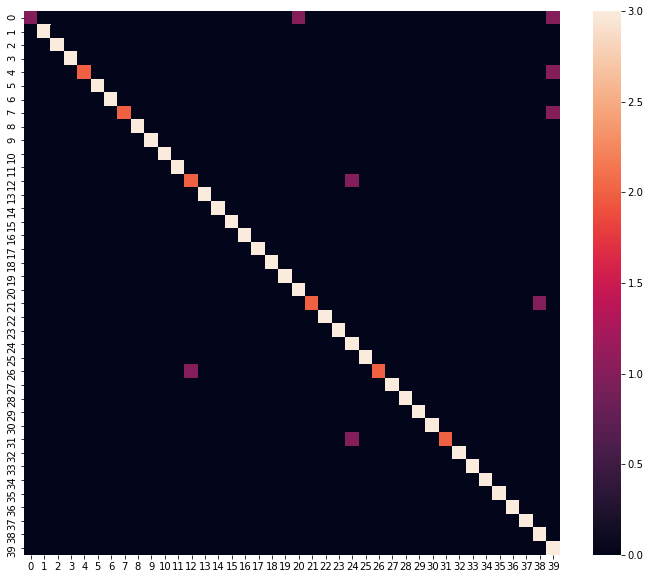



======= МОДЕЛЬ NB =======
Точность составляет: 0.86
Затраченное время в секундах: 0.0074

              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       1.00      0.67      0.80         3
           2       0.50      0.67      0.57         3
           3       0.60      1.00      0.75         3
           4       1.00      0.67      0.80         3
           5       1.00      0.67      0.80         3
           6       0.60      1.00      0.75         3
           7       0.67      0.67      0.67         3
           8       1.00      1.00      1.00         3
           9       0.67      0.67      0.67         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      0.33      0.50         3
          13       1.00      1.00      1.00         3
          14       1.00      0.67      0.80         3
          15       0.60      1.00      0.75

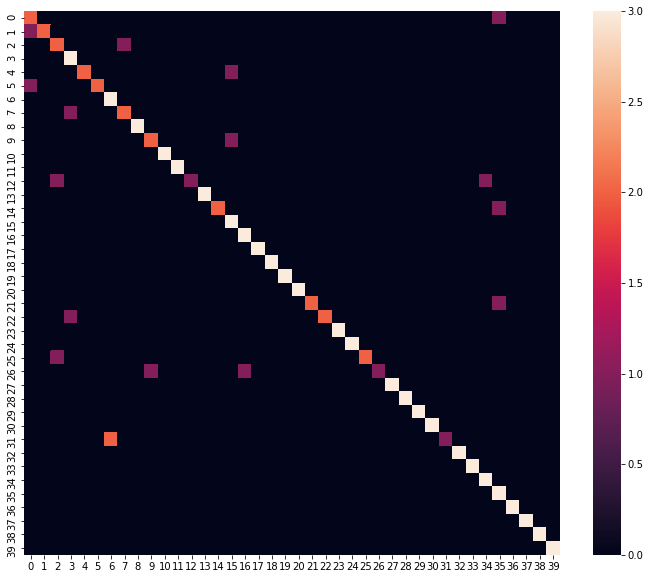

In [45]:
from timeit import default_timer as timer

models = []

models.append(("SVM", SVC()))
models.append(("KNN", KNeighborsClassifier(n_neighbors=5)))
models.append(("LR", LogisticRegression()))
models.append(("DT", DecisionTreeClassifier()))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("NB", GaussianNB()))


data = {"Модель": [], "Точность": [], "Затраченное время": []}

for name, model in models:
    clf = model
    start = timer()
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    end = timer()
    
    print(7 * "=", "Модель {}".format(name).upper(), 7 * "=")
    print("Точность составляет: {:0.2f}".format(metrics.accuracy_score(y_test, y_pred)))
    print("Затраченное время в секундах: {:0.4f}".format(end - start))
    
    data["Модель"].append(model)
    data["Точность"].append(metrics.accuracy_score(y_test, y_pred))
    data["Затраченное время"].append(end - start)
    
    print()
    print(metrics.classification_report(y_test, y_pred))
    print()
    plt.figure(1, figsize = (12 ,10))
    sns.heatmap(metrics.confusion_matrix(y_test, y_pred))
    plt.show()
    print()
    print()

Исходя из полученных результатов имеем, что модели линейного дискриминантного анализа и логистической регрессии добились наивысшей точности.

In [47]:
df = pd.DataFrame(data)

In [48]:
df

,Модель,Точность,Затраченное время
0,SVC(),0.916667,0.031074
1,KNeighborsClassifier(),0.700000,0.008889
2,LogisticRegression(),0.925000,0.041755
3,DecisionTreeClassifier(),0.600000,0.025904
4,LinearDiscriminantAnalysis(),0.933333,0.008832
5,GaussianNB(),0.858333,0.007369


<a></a>**GridSearchCV: оптимальные гиперпараметры** 

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
lr = LogisticRegression(C=1.0, penalty="l2")
lr.fit(X_train_pca, y_train)

print("lr score:{:.2f}".format(lr.score(X_test_pca, y_test)))

lr score:0.93


<a></a>**Кривые precision-recall** 

In [42]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

Target = label_binarize(target, classes=range(40))

n_classes=Target.shape[1]

precision = dict()
recall = dict()
average_precision = dict()


X_train_multiclass, X_test_multiclass, y_train_multiclass,  y_test_multiclass = train_test_split(X, 
                                                                                                 Target, 
                                                                                                 test_size=0.3, 
                                                                                                 stratify=Target, 
                                                                                                 random_state=0)

pca = PCA(n_components = n_components, whiten=True)
pca.fit(X_train_multiclass)

X_train_multiclass_pca = pca.transform(X_train_multiclass)
X_test_multiclass_pca = pca.transform(X_test_multiclass)

oneRestClassifier = OneVsRestClassifier(lr)

oneRestClassifier.fit(X_train_multiclass_pca, y_train_multiclass)
y_score = oneRestClassifier.decision_function(X_test_multiclass_pca)

for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_test_multiclass[:, i], y_score[:, i])
    average_precision[i] = metrics.average_precision_score(y_test_multiclass[:, i], y_score[:, i])

precision["micro"], recall["micro"], _ = metrics.precision_recall_curve(y_test_multiclass.ravel(), y_score.ravel())
average_precision["micro"] = metrics.average_precision_score(y_test_multiclass, y_score, average="micro")

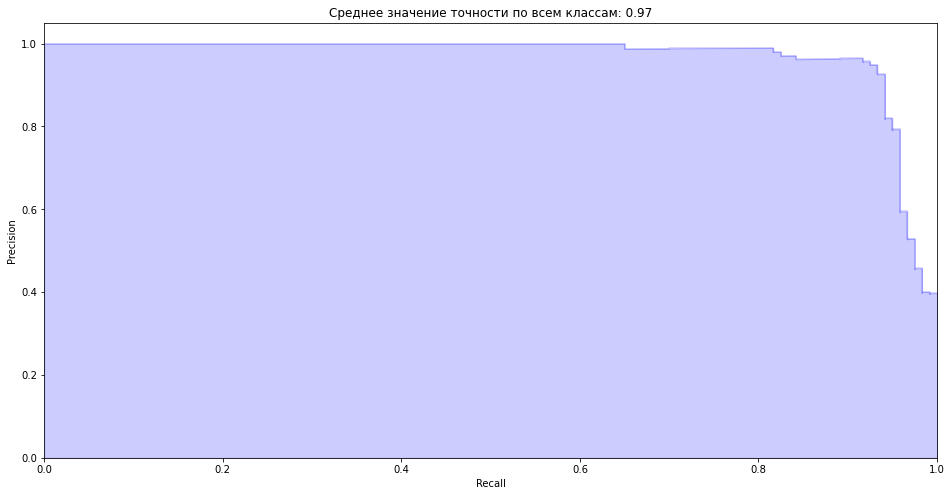

In [49]:
# !pip install funcsigs
from funcsigs import signature

step_kwargs = ({"step": "post"}
               if "step" in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (16,8))
plt.step(recall["micro"], precision["micro"], color="b", alpha=0.2, where="post")

plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color="b", **step_kwargs)

plt.xlabel("Recall")
plt.ylabel("Precision")

plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Среднее значение точности по всем классам: {0:0.2f}".format(average_precision["micro"]))
plt.show()